In [25]:
import math
import numpy as np
import json
import pandas as pd
import glob

from src.constants import OUTPUTS_DIR

In [26]:
experiment_file_2 = OUTPUTS_DIR / "train_turboae_window_5.json"
experiment_file_1 = OUTPUTS_DIR / "train_turboae_window_9.json"
experiment_file_3 = OUTPUTS_DIR / "train_turboae_original.json"
experiment_file_4 = OUTPUTS_DIR / "train_turboae_window_5_no_front_no_first.json"
experiment_file_5 = OUTPUTS_DIR / "train_turboae_window_5_no_front_first.json"
experiment_file_6 = OUTPUTS_DIR / "train_turboae_window_5_no_front_first_2.json"
experiment_file_7 = OUTPUTS_DIR / "train_turboae_window_5_no_front_first_2_small_batch.json"
experiment_file_8 = OUTPUTS_DIR / "train_turboae_w5_first_no_front_small_batch.json"
experiment_file_9 = OUTPUTS_DIR / "train_turboae_table_w5_small_batch.json"
experiment_file_10 = OUTPUTS_DIR / "train_turboae_w9_first_no_front_small_batch_block_len_40.json"
experiment_file_11 = OUTPUTS_DIR / "train_turboae_w9_first_no_front_small_batch_block_len_40_reload_1.json"
experiment_file_12 = OUTPUTS_DIR / "train_turboae_w9_first_no_front_small_batch_block_len_40_2.json"




exp_files = []
# exp_files.append(experiment_file_1)
# exp_files.append(experiment_file_2)
exp_files.append(experiment_file_3)
# exp_files.append(experiment_file_4)
# exp_files.append(experiment_file_5)
# exp_files.append(experiment_file_6)
# exp_files.append(experiment_file_7)
# exp_files.append(experiment_file_8)
# exp_files.append(experiment_file_9)
exp_files.append([experiment_file_10, experiment_file_11])
exp_files.append(experiment_file_12)

In [27]:
from typing import List

def canonicalize(item: str | List[str]):
    if isinstance(item, list):
        return item
    else:
        return [item]

training_runs = []
validation_runs = []
for gby_key, exp_file_list in enumerate(exp_files):
    exp_file_list = canonicalize(exp_file_list)
    training_results_this_run = []
    validation_results_this_run = []
    for exp_file in exp_file_list:
        with open(exp_file, "r") as e:
            results = json.load(e)
        for d in results["data"]:
            if "results" not in d:
                continue
            
            i = 0
            for res in d["results"]:
                if "xe__mean" in res:
                    res["type"] = "validation"
                    res["step"] = i
                else:
                    res["type"] = "training"
                    res["step"] = i
                    i += 1
            training_results = pd.DataFrame([res for res in d["results"] if res["type"] == "training"])
            validation_results = pd.DataFrame([{**res, "step": (d["results"][i-1]["step"] + 1 if i > 0 else 0)} for i, res in enumerate(d["results"]) if res["type"] == "validation"])
            preambles = pd.DataFrame([{**d["preamble"]["args"], **d["preamble"]}])
            training_results = training_results.merge(preambles, how="cross")
            validation_results = validation_results.merge(preambles, how="cross")
            training_results_this_run.append(training_results)
            validation_results_this_run.append(validation_results)
    training_results = pd.concat(training_results_this_run, axis=0)
    validation_results = pd.concat(validation_results_this_run, axis=0)
    training_results["gby_key"] = gby_key
    validation_results["gby_key"] = gby_key
    
    training_runs.append(training_results)
    validation_runs.append(validation_results)

training = pd.concat(training_runs, axis=0)
validation = pd.concat(validation_runs, axis=0)

arg_select_cols = ["block_len", "enc_kernel_size", "argument_hash", "experiment_id", "gby_key"]
training_select_cols = ["xe", "ber", "bler", "step", "epoch", "train_type", "grad_avg_l2", "grad_avg_linf", "update_avg_l2", "update_avg_linf"]
val_select_cols = ["xe__mean", "ber__mean", "bler__mean", "xe__err", "ber__err", "bler__err", "epoch", ]

training = training[training_select_cols + arg_select_cols]
validation = validation[val_select_cols + arg_select_cols]

# lr_filter = [0.01]
# training = training[training["adam_lr"].isin(lr_filter)]
# validation = validation[validation["adam_lr"].isin(lr_filter)]

display(training.head())
display(validation.head())

# def add_col(df: pd.DataFrame, col_name, data):
#     print(len(df))
#     print(data)
#     df = df.copy()
#     new_data = pd.DataFrame([data], columns=[col_name])
#     new_data.index = df.index
#     df = pd.concat([df, new_data], axis=1)
#     print(df)
#     print(df[col_name])
#     df.info()
#     return df

# training = training.groupby(["block_len", "enc_kernel_size", "train_type", "argument_hash"]) \
#     .apply(lambda x: add_col(x.sort_values(by=["epoch", "step"]), "train_step", pd.Series(list(range(x.shape[0])), dtype=int)))
    
# training[training["train_type"] == "encoder"]

,xe,ber,bler,step,epoch,train_type,grad_avg_l2,grad_avg_linf,update_avg_l2,update_avg_linf,block_len,enc_kernel_size,argument_hash,experiment_id,gby_key
0,0.695196,0.576530,1.0,0,0,encoder,0.085936,0.007903,0.038954,0.000100,100,5,06413bbd7f8b3f80d832ad3b6f1afe810aad8519,train_turboae_original,0
1,0.693443,0.506785,1.0,1,0,encoder,0.080784,0.007216,0.035461,0.000100,100,5,06413bbd7f8b3f80d832ad3b6f1afe810aad8519,train_turboae_original,0
2,0.691829,0.443745,1.0,2,0,encoder,0.074425,0.006409,0.031155,0.000100,100,5,06413bbd7f8b3f80d832ad3b6f1afe810aad8519,train_turboae_original,0
3,0.690485,0.389660,1.0,3,0,encoder,0.068706,0.005596,0.029979,0.000101,100,5,06413bbd7f8b3f80d832ad3b6f1afe810aad8519,train_turboae_original,0
4,0.689240,0.339440,1.0,4,0,encoder,0.063448,0.004981,0.030462,0.000101,100,5,06413bbd7f8b3f80d832ad3b6f1afe810aad8519,train_turboae_original,0


,xe__mean,ber__mean,bler__mean,xe__err,ber__err,bler__err,epoch,block_len,enc_kernel_size,argument_hash,experiment_id,gby_key
0,0.695219,0.577416,1.00000,0.000014,0.000691,0.000000,0,100,5,06413bbd7f8b3f80d832ad3b6f1afe810aad8519,train_turboae_original,0
1,0.040246,0.014435,0.76715,0.000344,0.000168,0.005977,10,100,5,06413bbd7f8b3f80d832ad3b6f1afe810aad8519,train_turboae_original,0
2,0.019145,0.006708,0.43830,0.000309,0.000134,0.007017,20,100,5,06413bbd7f8b3f80d832ad3b6f1afe810aad8519,train_turboae_original,0
3,0.015780,0.005507,0.35695,0.000320,0.000129,0.006776,30,100,5,06413bbd7f8b3f80d832ad3b6f1afe810aad8519,train_turboae_original,0
4,0.012057,0.004165,0.28745,0.000266,0.000112,0.006401,40,100,5,06413bbd7f8b3f80d832ad3b6f1afe810aad8519,train_turboae_original,0


In [28]:
training[training["experiment_id"] == "train_turboae_table_w5_small_batch"].head()

,xe,ber,bler,step,epoch,train_type,grad_avg_l2,grad_avg_linf,update_avg_l2,update_avg_linf,block_len,enc_kernel_size,argument_hash,experiment_id,gby_key


In [29]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

def make_training_plots(df: pd.DataFrame, plot_key: str, com: float = 50.0, ylabel: str = None):
    for (_, train_type), training_result in df.groupby(["gby_key", "train_type"], dropna=False):
        if len(training_result) < 100:
            continue
        print(len(training_result))
        exp_id = training_result["experiment_id"].iloc[0]
        block_len = training_result["block_len"].iloc[0]
        enc_kernel_size = training_result["enc_kernel_size"].iloc[0]
        
        fig = plt.figure(figsize=(4, 3), dpi=100)
        ax = fig.add_axes([0.1, 0.1, .85, .85])  # Last two terms control height and width
        capsize = 2
        
        num_eps = np.count_nonzero(training_result["epoch"].values[1:] - training_result["epoch"].values[:-1]) + 1
        print(num_eps)
        print(training_result["epoch"].max())
        num_results = training_result.shape[0]
        x_axis = (np.arange(num_results) / num_results * num_eps)
        
        ax.errorbar(
            x_axis, 
            training_result[plot_key], 
            # yerr=exp_result["xe__err"], 
            linestyle='-',
            capsize=capsize,
            label=f"block_len={block_len}:ks={enc_kernel_size}:{train_type}"
        )
        ax.errorbar(
            x_axis, 
            training_result[plot_key].ewm(com=com).mean(), 
            # yerr=exp_result["xe__err"], 
            linestyle='-',
            capsize=capsize,
            label=f"block_len={block_len}:ks={enc_kernel_size}:{train_type}"
        )
        ax.legend(bbox_to_anchor=[0.0, 1.25])
        ax.set_yscale('log')
        # ax.set_xscale('log')
        ax.set_xlabel('epoch')
        if ylabel is None:
            ylabel = plot_key
        ax.set_ylabel(ylabel)
        ax.set_title(exp_id)

        display(fig)

11862
95
94


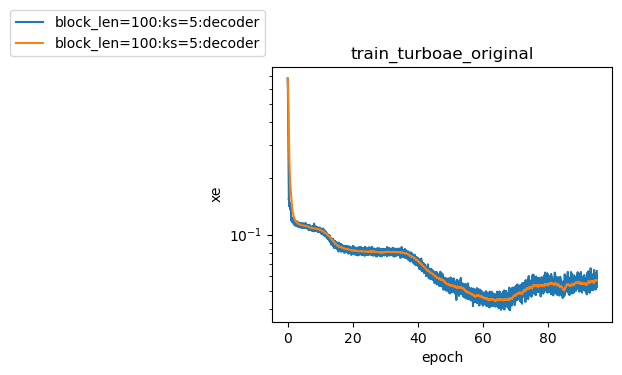

2375
95
94


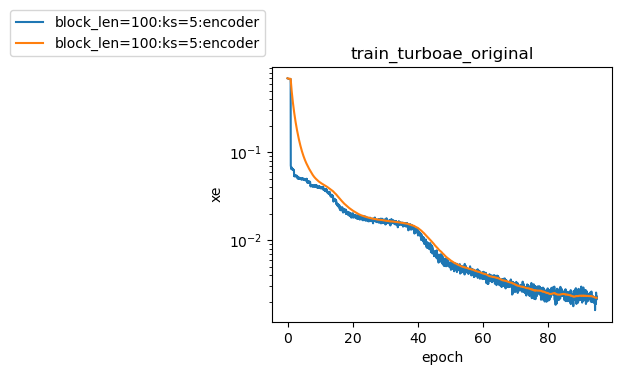

123797
991
800


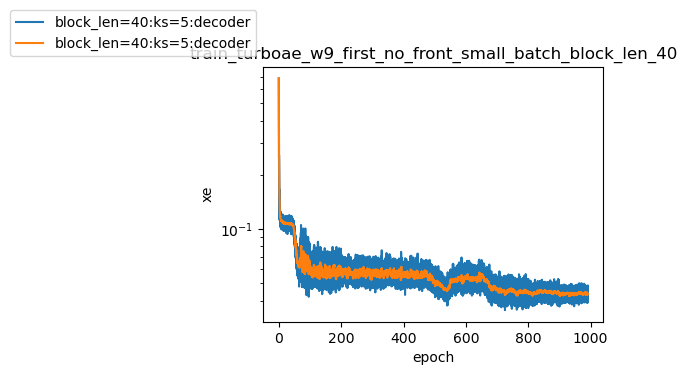

24775
991
800


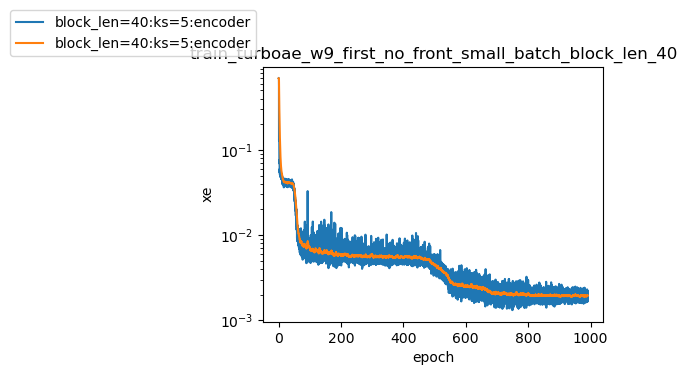

93673
750
750


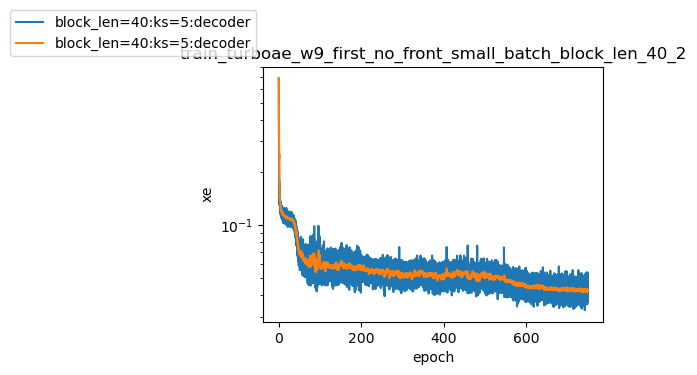

18750
750
750


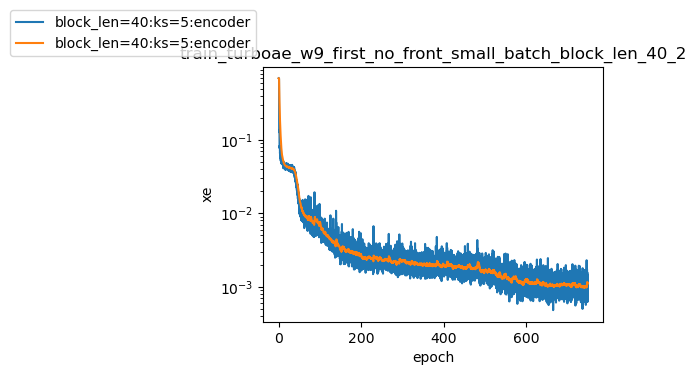

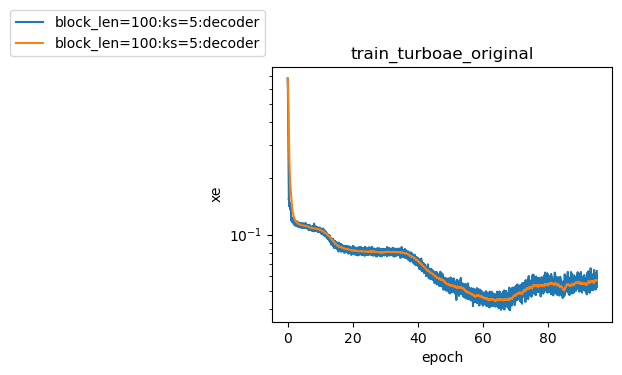

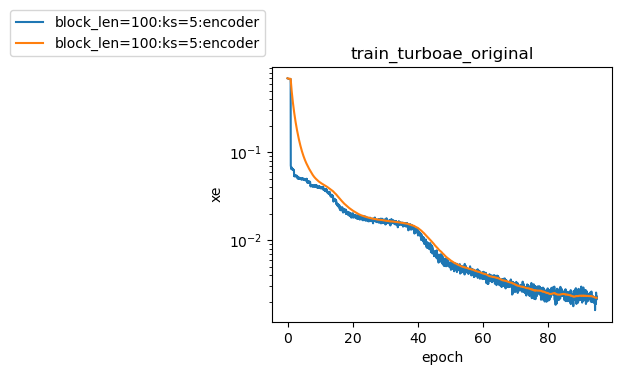

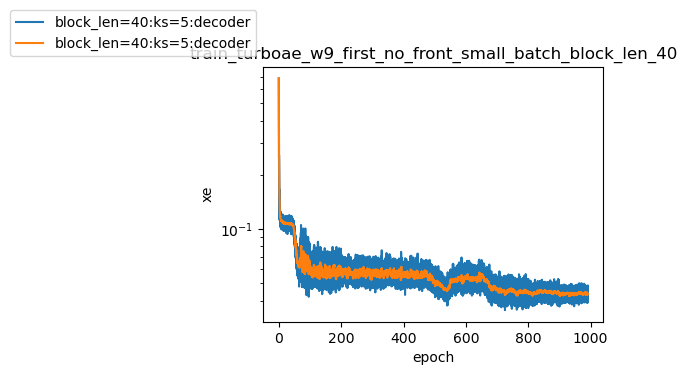

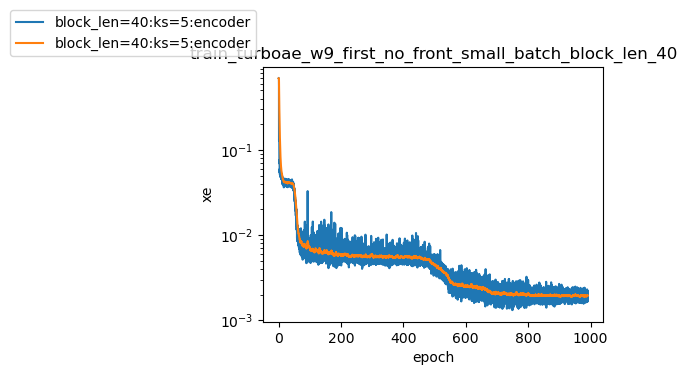

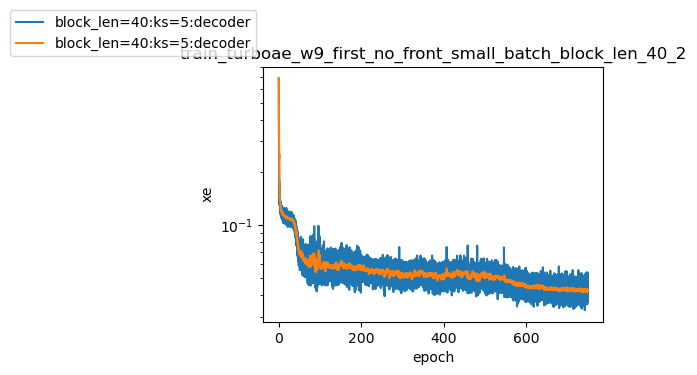

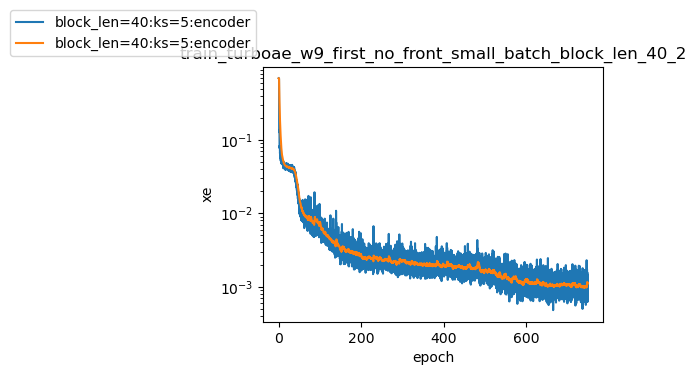

In [30]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

make_training_plots(training, plot_key="xe")

11862
95
94


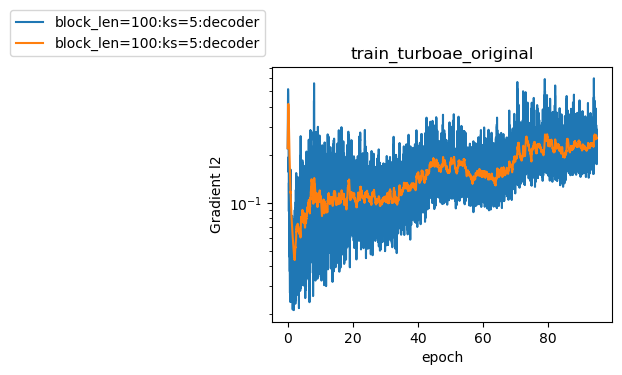

2375
95
94


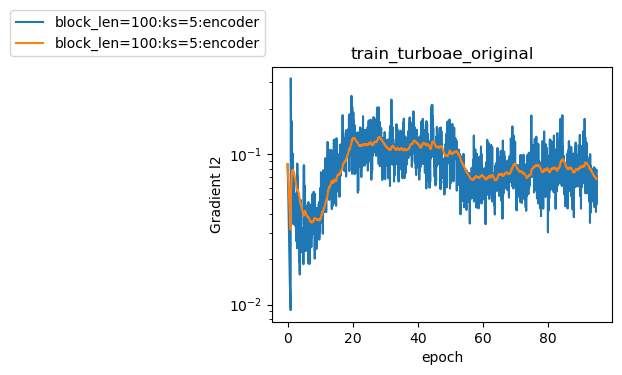

123797
991
800


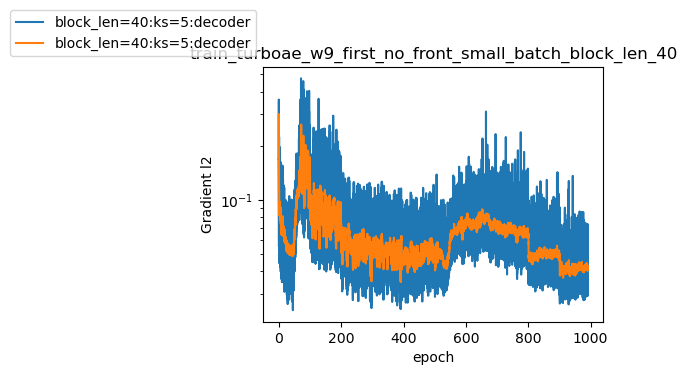

24775
991
800


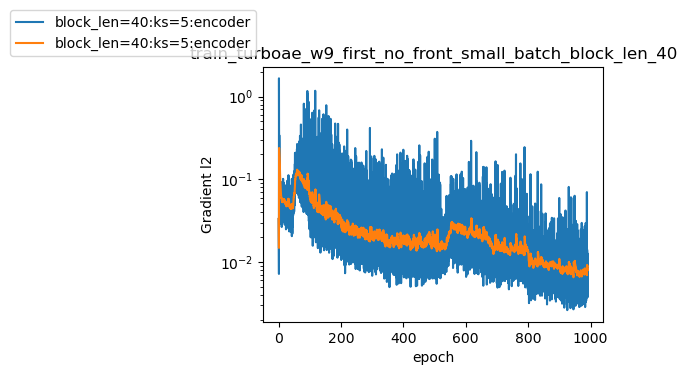

93673
750
750


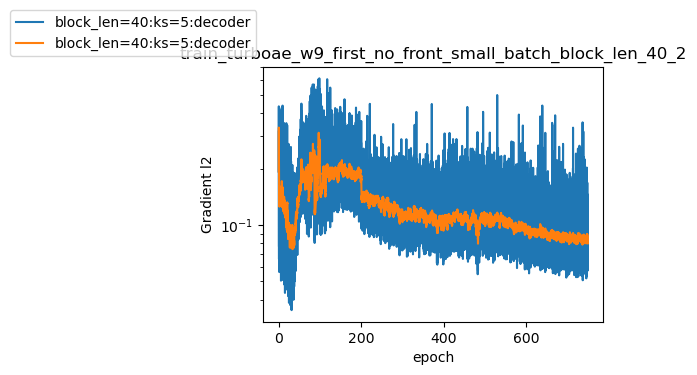

18750
750
750


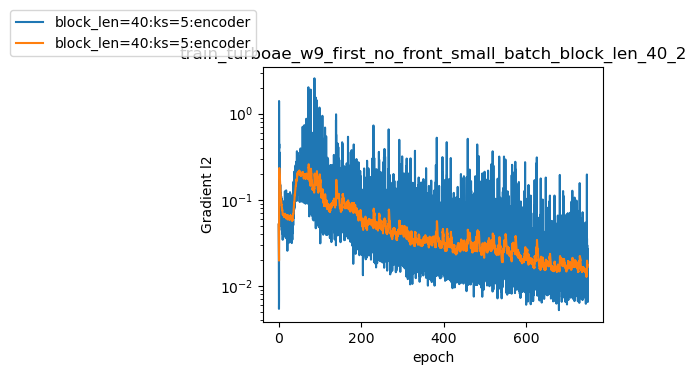

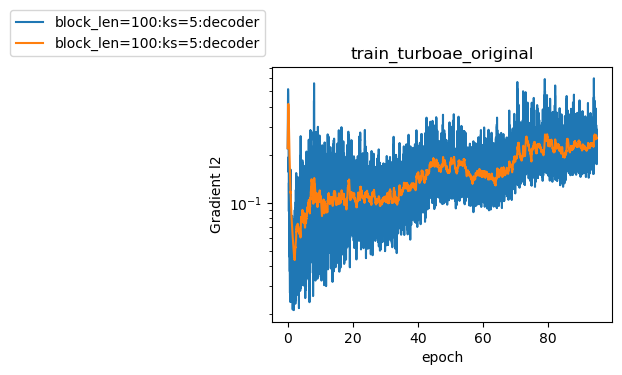

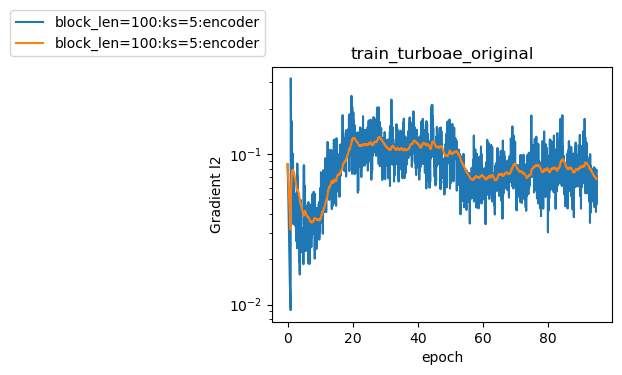

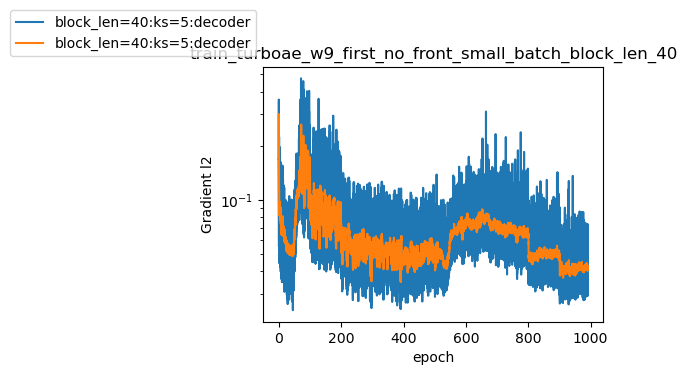

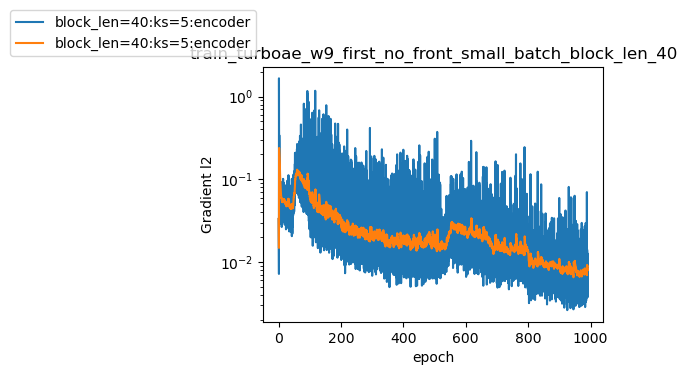

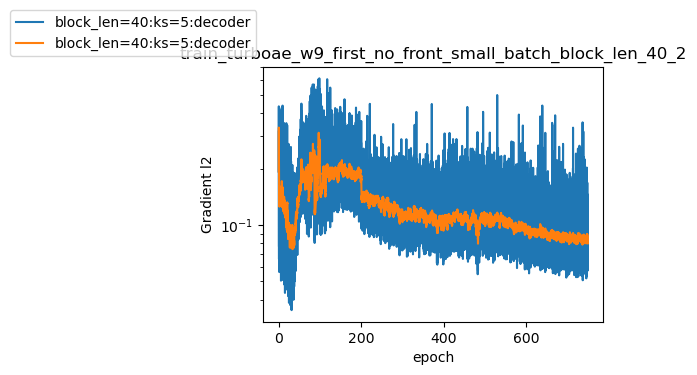

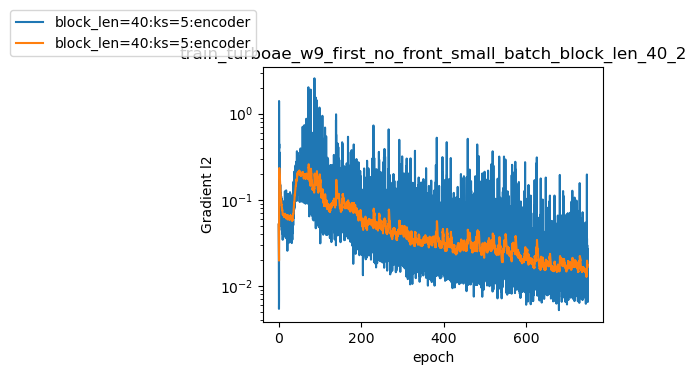

In [31]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

make_training_plots(training, plot_key="grad_avg_l2", ylabel="Gradient l2")

11862
95
94


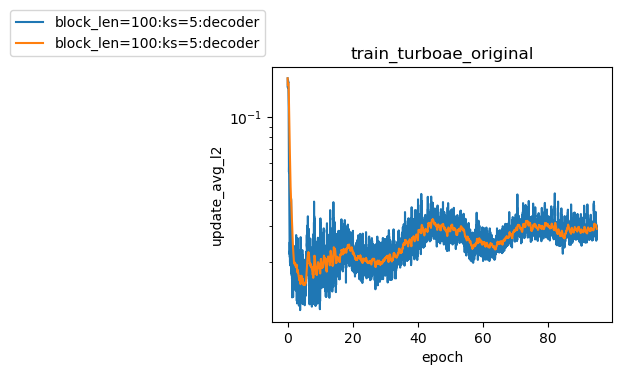

2375
95
94


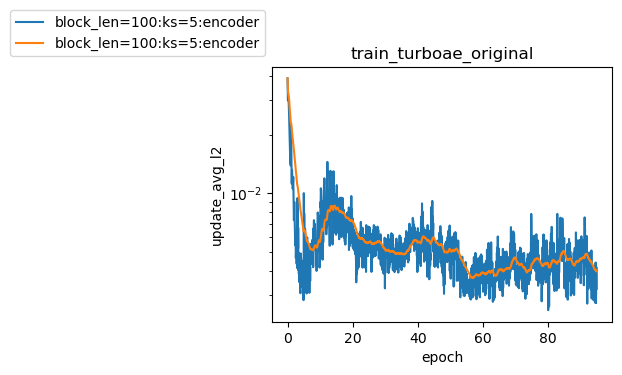

123797
991
800


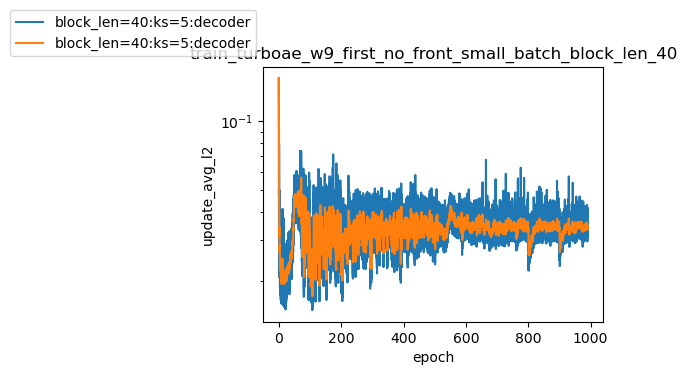

24775
991
800


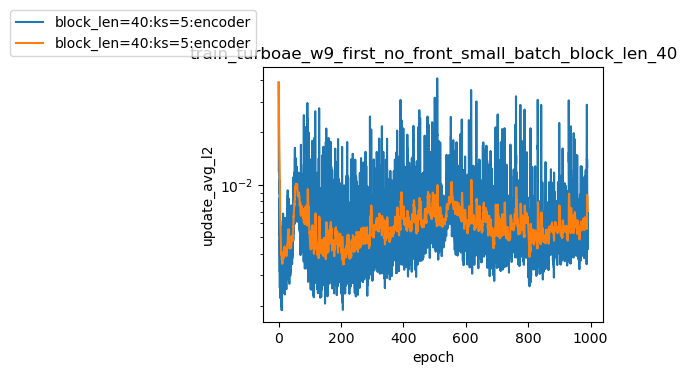

93673
750
750


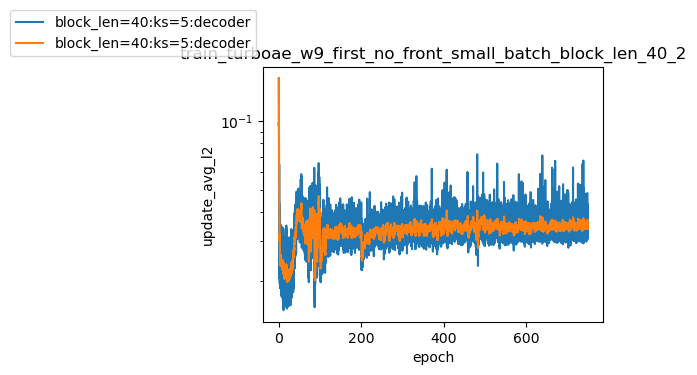

18750
750
750


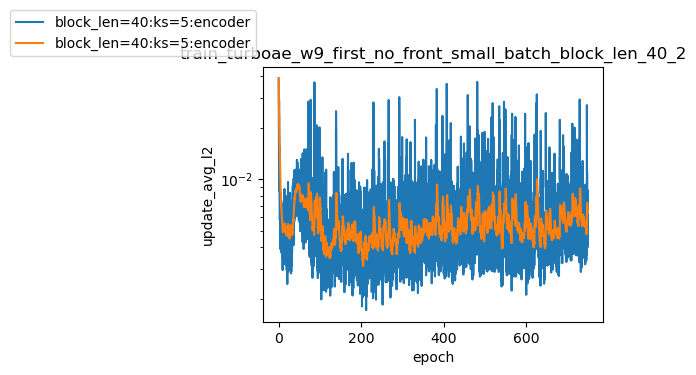

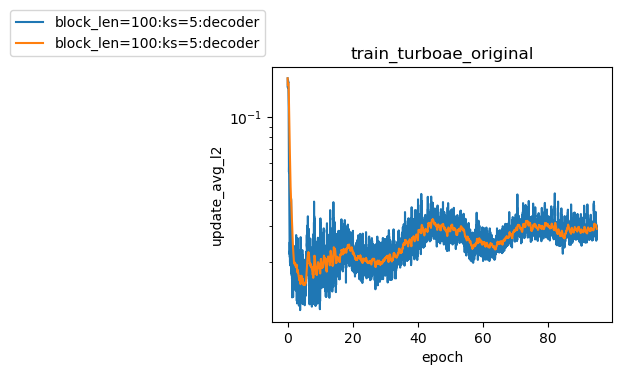

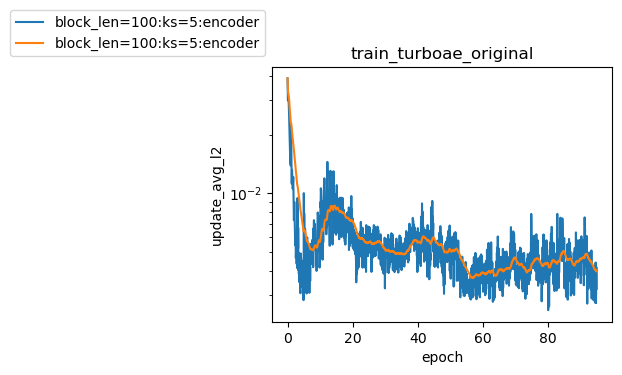

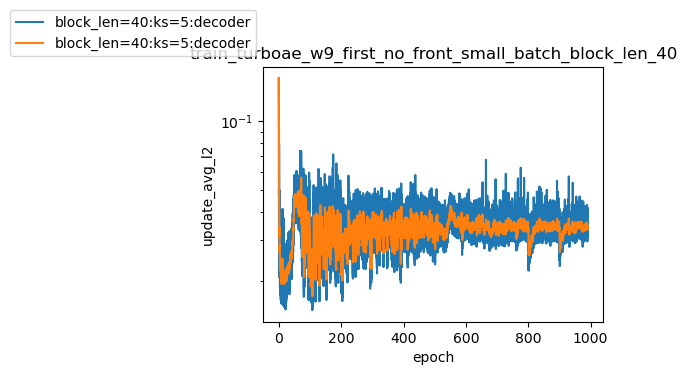

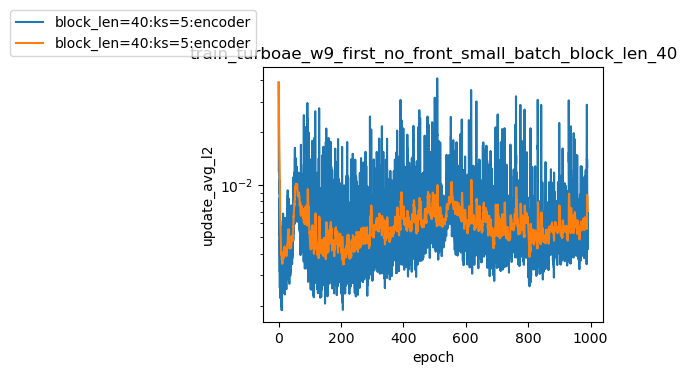

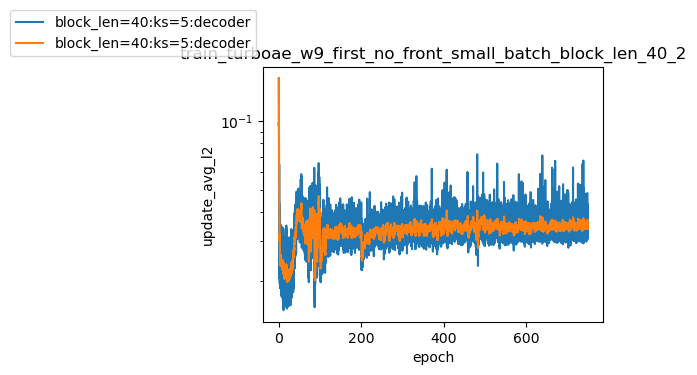

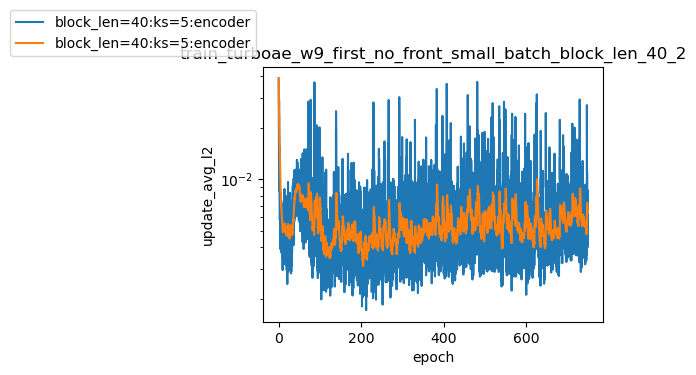

In [32]:
make_training_plots(training, plot_key="update_avg_l2")

11862
95
94


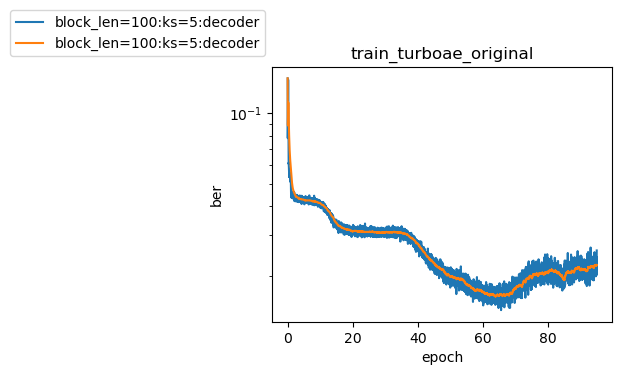

2375
95
94


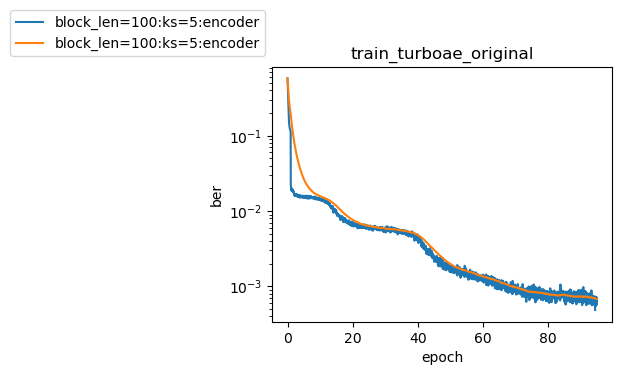

123797
991
800


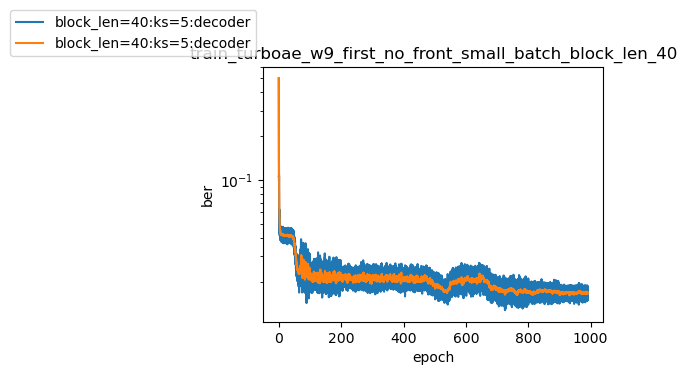

24775
991
800


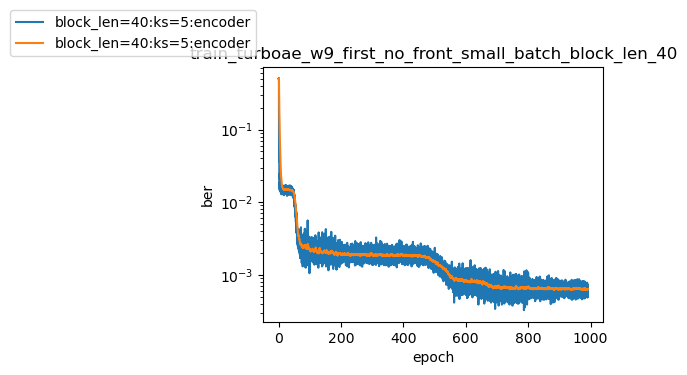

93673
750
750


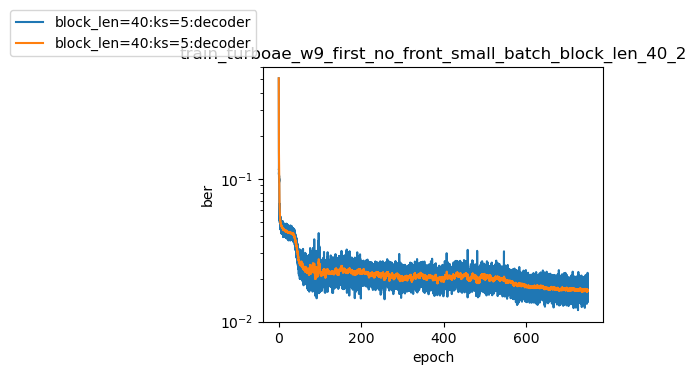

18750
750
750


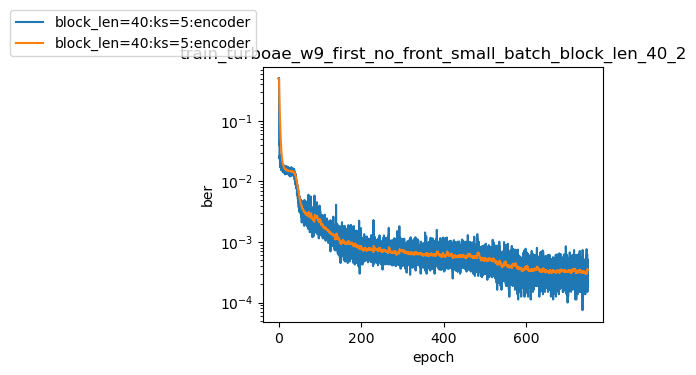

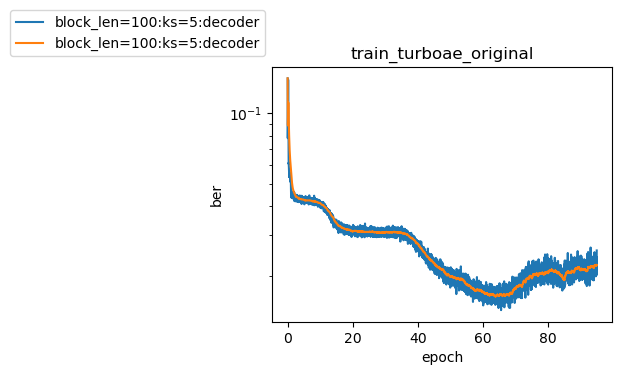

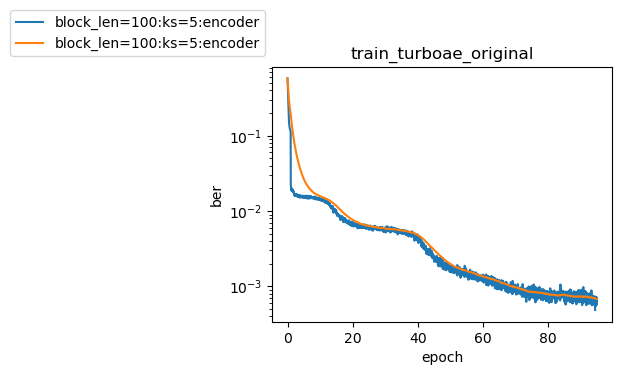

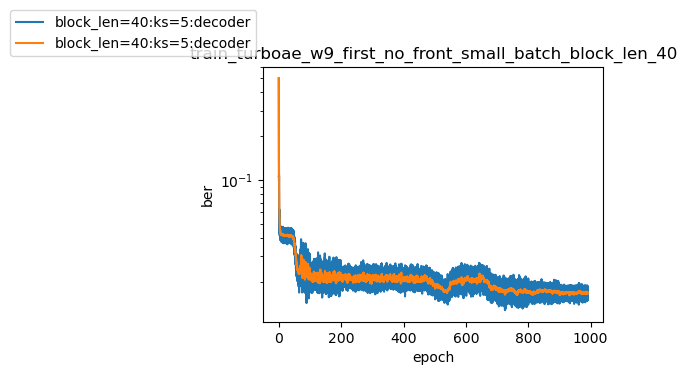

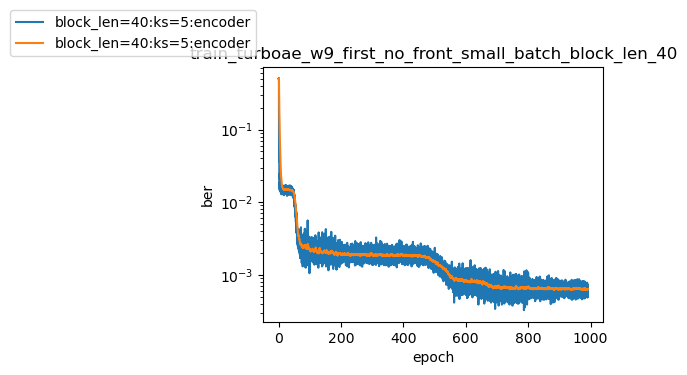

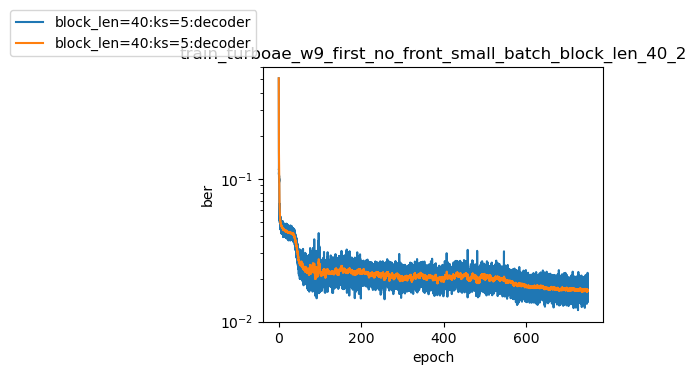

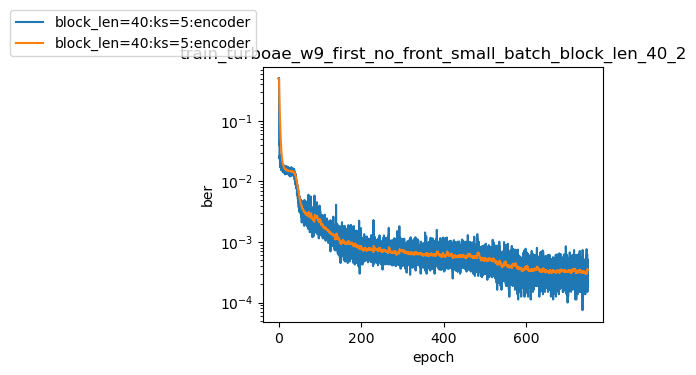

In [33]:
make_training_plots(training, plot_key="ber")

In [34]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

def make_validation_plots(df: pd.DataFrame, plot_key: str, com: float = 50.0, ylabel: str = None):
    for _, validation_result in df.groupby(["gby_key"], dropna=False):
        # if len(validation_result) < 100:
        #     continue
        # print(len(training_result))
        fig = plt.figure(figsize=(4, 3), dpi=100)
        ax = fig.add_axes([0.1, 0.1, .85, .85])  # Last two terms control height and width
        capsize = 2
        
        exp_id = validation_result["experiment_id"].iloc[0]
        block_len = validation_result["block_len"].iloc[0]
        enc_kernel_size = validation_result["enc_kernel_size"].iloc[0]
        
        # num_eps = np.sum(validation_result["epoch"].values[1:] - validation_result["epoch"].values[:-1]) + validation_result["epoch"].values[0]
        num_eps = np.sum(validation_result["epoch"].values[1] - validation_result["epoch"].values[0]) * (len(validation_result["epoch"].values) - 1) + validation_result["epoch"].values[0]
        print(num_eps)
        print(validation_result["epoch"].max())
        num_results = validation_result.shape[0]
        x_axis = (np.arange(num_results) / num_results * num_eps)
        
        ax.errorbar(
            x_axis, 
            validation_result[f"{plot_key}__mean"], 
            yerr=validation_result[f"{plot_key}__err"], 
            linestyle='-',
            capsize=capsize,
            label=f"block_len={block_len}:ks={enc_kernel_size}"
        )
        # ax.errorbar(
        #     x_axis, 
        #     validation_result[plot_key].ewm(com=com).mean(), 
        #     # yerr=exp_result["xe__err"], 
        #     linestyle='-',
        #     capsize=capsize,
        #     label=f"block_len={block_len}:ks={enc_kernel_size}:{train_type}"
        # )
        ax.legend(bbox_to_anchor=[0.0, 1.25])
        ax.set_yscale('log')
        # ax.set_xscale('log')
        ax.set_xlabel('epoch')
        if ylabel is None:
            ylabel = plot_key
        ax.set_ylabel(ylabel)
        ax.set_title(exp_id)

        display(fig)

90
90


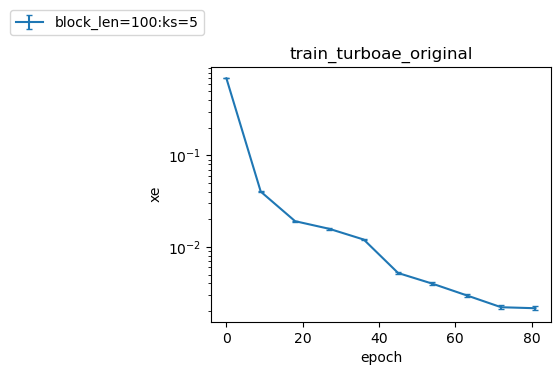

1030
800


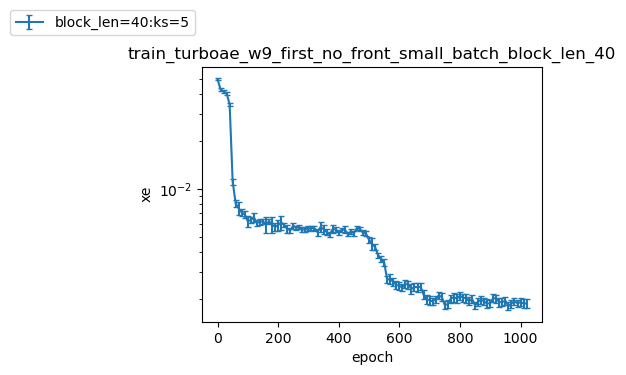

770
750


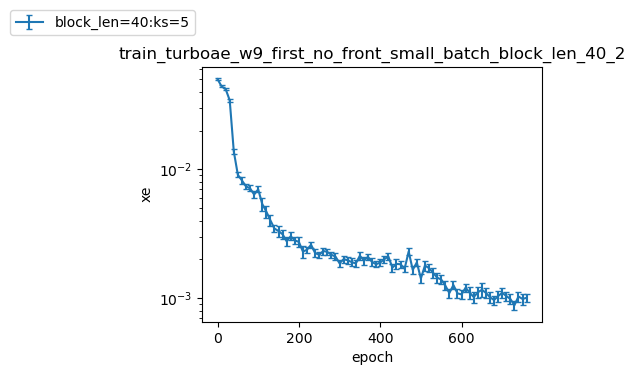

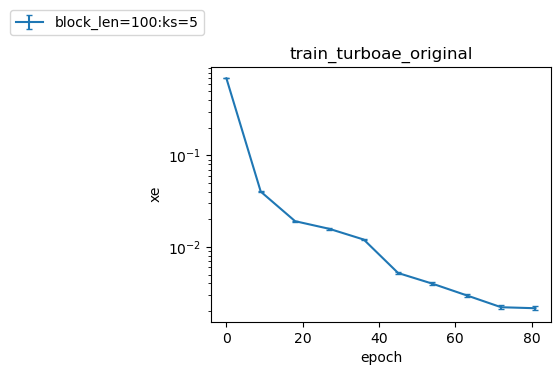

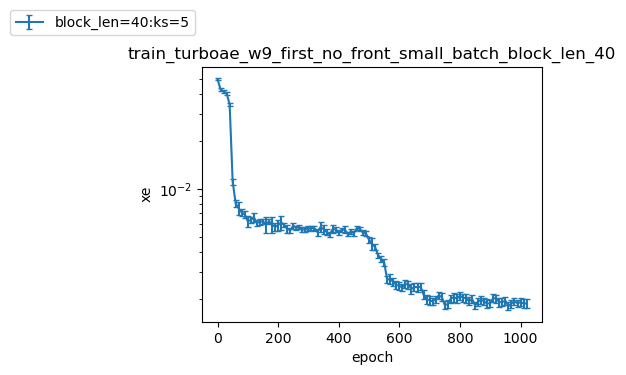

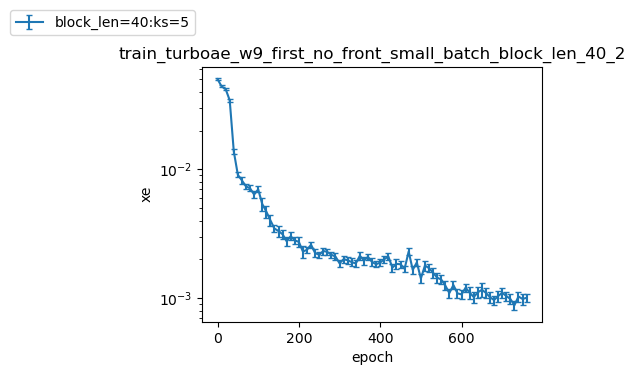

In [35]:
make_validation_plots(df=validation, plot_key="xe")

90
90


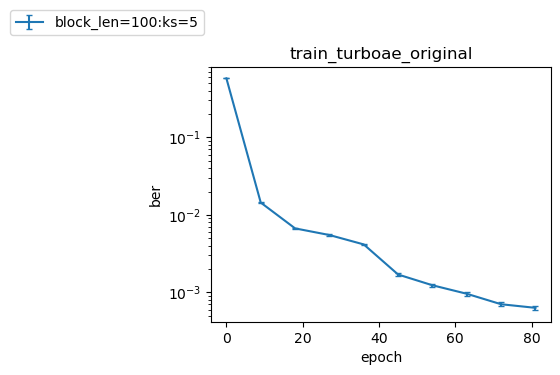

1030
800


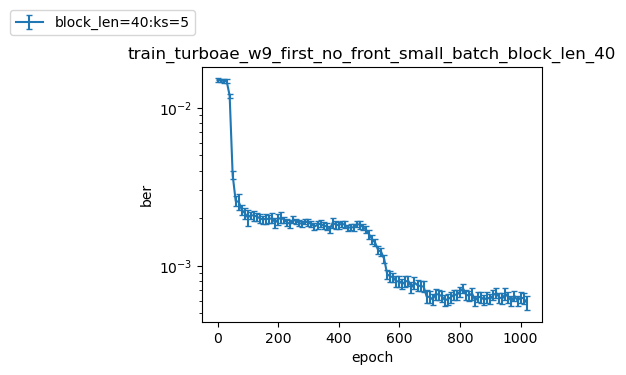

770
750


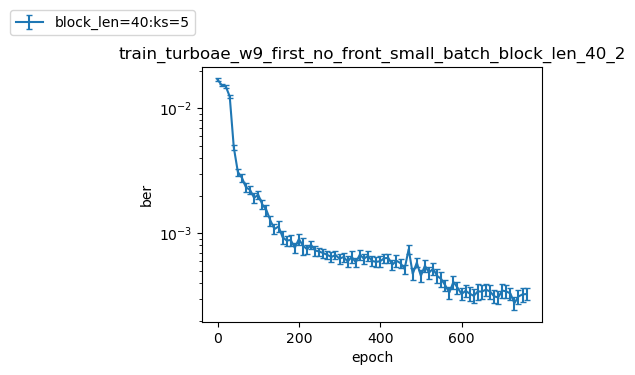

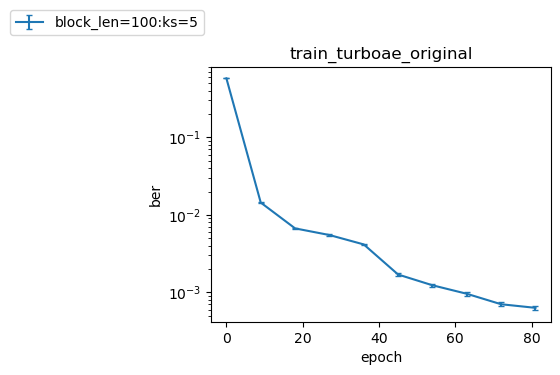

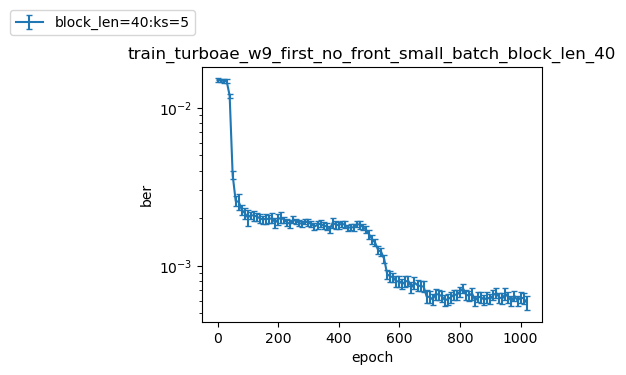

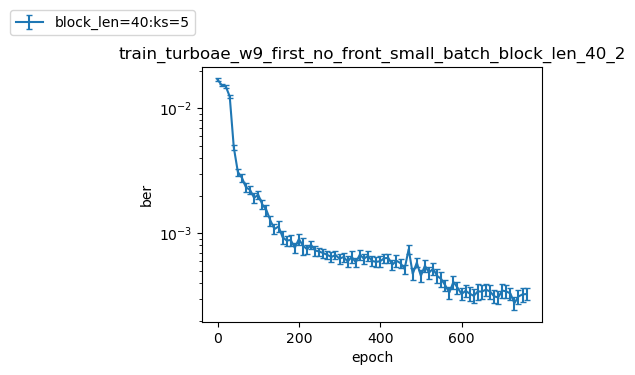

In [36]:
make_validation_plots(df=validation, plot_key="ber")